## Introduction: The Compact Muon Solenoid (CMS) experiment

The CMS experiment is a key research project at the Large Hadron Collider (LHC). It's a particle physics detector that observes and measures the byproducts of high-energy particle collisions in the LHC. CMS is designed to investigate a wide range of physics phenomena, and it played a pivotal role in the discovery of the Higgs boson in 2012.

CMS is a general-purpose detector, meaning it's equipped to study various aspects of particle physics. Its main components include a superconducting solenoid magnet, various particle detectors, and systems for tracking, energy measurement, and muon detection. This sophisticated setup allows scientists to explore several key questions in fundamental physics, such as the properties of the Higgs boson, the search for supersymmetry, the nature of dark matter, and potential evidence of extra dimensions.

<!-- insert cms image below -->
![A detailed picture of the CMS detector](gfx/cms_detect.png)


### Measuring jets at CMS

In CMS, particle jets are crucial for understanding high-energy processes. They are sprays of particles formed when quarks and gluons, produced in high-energy collisions like those at the LHC, hadronize or turn into ordinary matter. By analyzing the jets' energy and momentum, physicists can infer properties of the original particles, helping in studies like proton structure, the strong force, and new physics beyond the Standard Model.

![How a jet is generated and reconstructed](gfx/jet_structure.png)


## Hands-on generative models with CMS-like data

In High Energy Physics (HEP), simulations are crucial for understanding the outcomes of particle collisions, like those observed in the CMS experiment. The general simulation process involves several steps:

- **Event generation** - simulating the initial high-energy collision and the primary processes that follow
- **Particle tracking** and interaction - simulating how the particles produced in the collision travel through and interact with the detector material
- **Detector response** - modeling how the detector responds to these particles
- **Data reconstruction** - processing the simulated detector signals to reconstruct what happened in the collision

These steps are computationally expensive due to the complex physics involved and the high precision required. Each collision can produce a multitude of particles, making the simulation of even a single event a resource-intensive task.

Machine Learning (ML) can significantly speed up this process, particularly the reconstruction phase. By training models to emulate the behavior of particles in the detector and their interaction, we can bypass the need for detailed, step-by-step simulation, reducing computation time and resource usage.

In this exercise, we aim to simulate **reconstruction-level** (reco-level) jets from **generator-level** (gen-level) data. For this purpose, we have prepared a dataset about 2M pairs of gen jets and their associated reco jets as produced by a CMS-like simulation script.


<div class="alert alert-block alert-success" style="background-color:lightgreen; color:green;">

<b>Problem statement:</b> Learn to simulate the features of reco-jets given the values of the associated gen-jet features. This exercise will involve building different ML models for predicting the properties of the reco-jets (like momentum, pseudorapidity, etc.) based on the known properties of the gen-jets.
</div>


### The dataset

We start by loading the dataset and describing the input and the target features. We load some libraries and define some plotting utilities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import nflows

from utils import plot_1dhistos, plot_corner


In [2]:
# we set the device to use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We pull the dataset from cernbox: it is a ttbar dataset of 400000 events, meaning more than 2M jets!

In [3]:
# !curl -o data.npy https://cernbox.cern.ch/remote.php/dav/public-files/YzEDEoU01hJNI2G/gen_ttbar_400k_final.npy

We then extract the data. We are going to use just a subset of the features to reduce the complexity of the problem, and load 1M jets to split into trainig/validation/test. Can you plot some histograms of the features to better understand what we are talking about? (remember that the Number of Constituents, N_const, is an integer variable so you need to use a linspace as binning!)

In [4]:
# a class to load the data taking only some of the features and dividing into reco (target) and gen (input)
class DataExtractor():
    def __init__(self, data_path, n_samples=None):
        self.data = np.load(data_path, allow_pickle=True)
        self.n_samples = n_samples
        self.data = self.data[:n_samples]
        self.reco_features = ['btag', 'pt', 'phi', 'eta', 'N_const', 'ctag']
        self.reco = self.data[:, [5,  6,  7,  8, 10, 19]]
        self.gen_features = ["pt", "eta", "phi", "E", "flavour", "muonsInJet",]
        self.gen = self.data[:, [0, 1, 2, 3, 4, 9]]
        # collapse flavour to 3 categories: 0 (light), 1 (charm), 2 (bottom)
        self.gen[:, 4] = np.abs(self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 1, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 2, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 3, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 21, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 5, 2, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 4, 1, self.gen[:, 4])

        
    def get_reco(self):
        return self.reco
    
    def get_gen(self):
        return self.gen

In [5]:
extractor = DataExtractor('data2.npy', n_samples=500000)
reco_data = extractor.get_reco()
reco_features = extractor.reco_features
gen_data = extractor.get_gen()
gen_features = extractor.gen_features

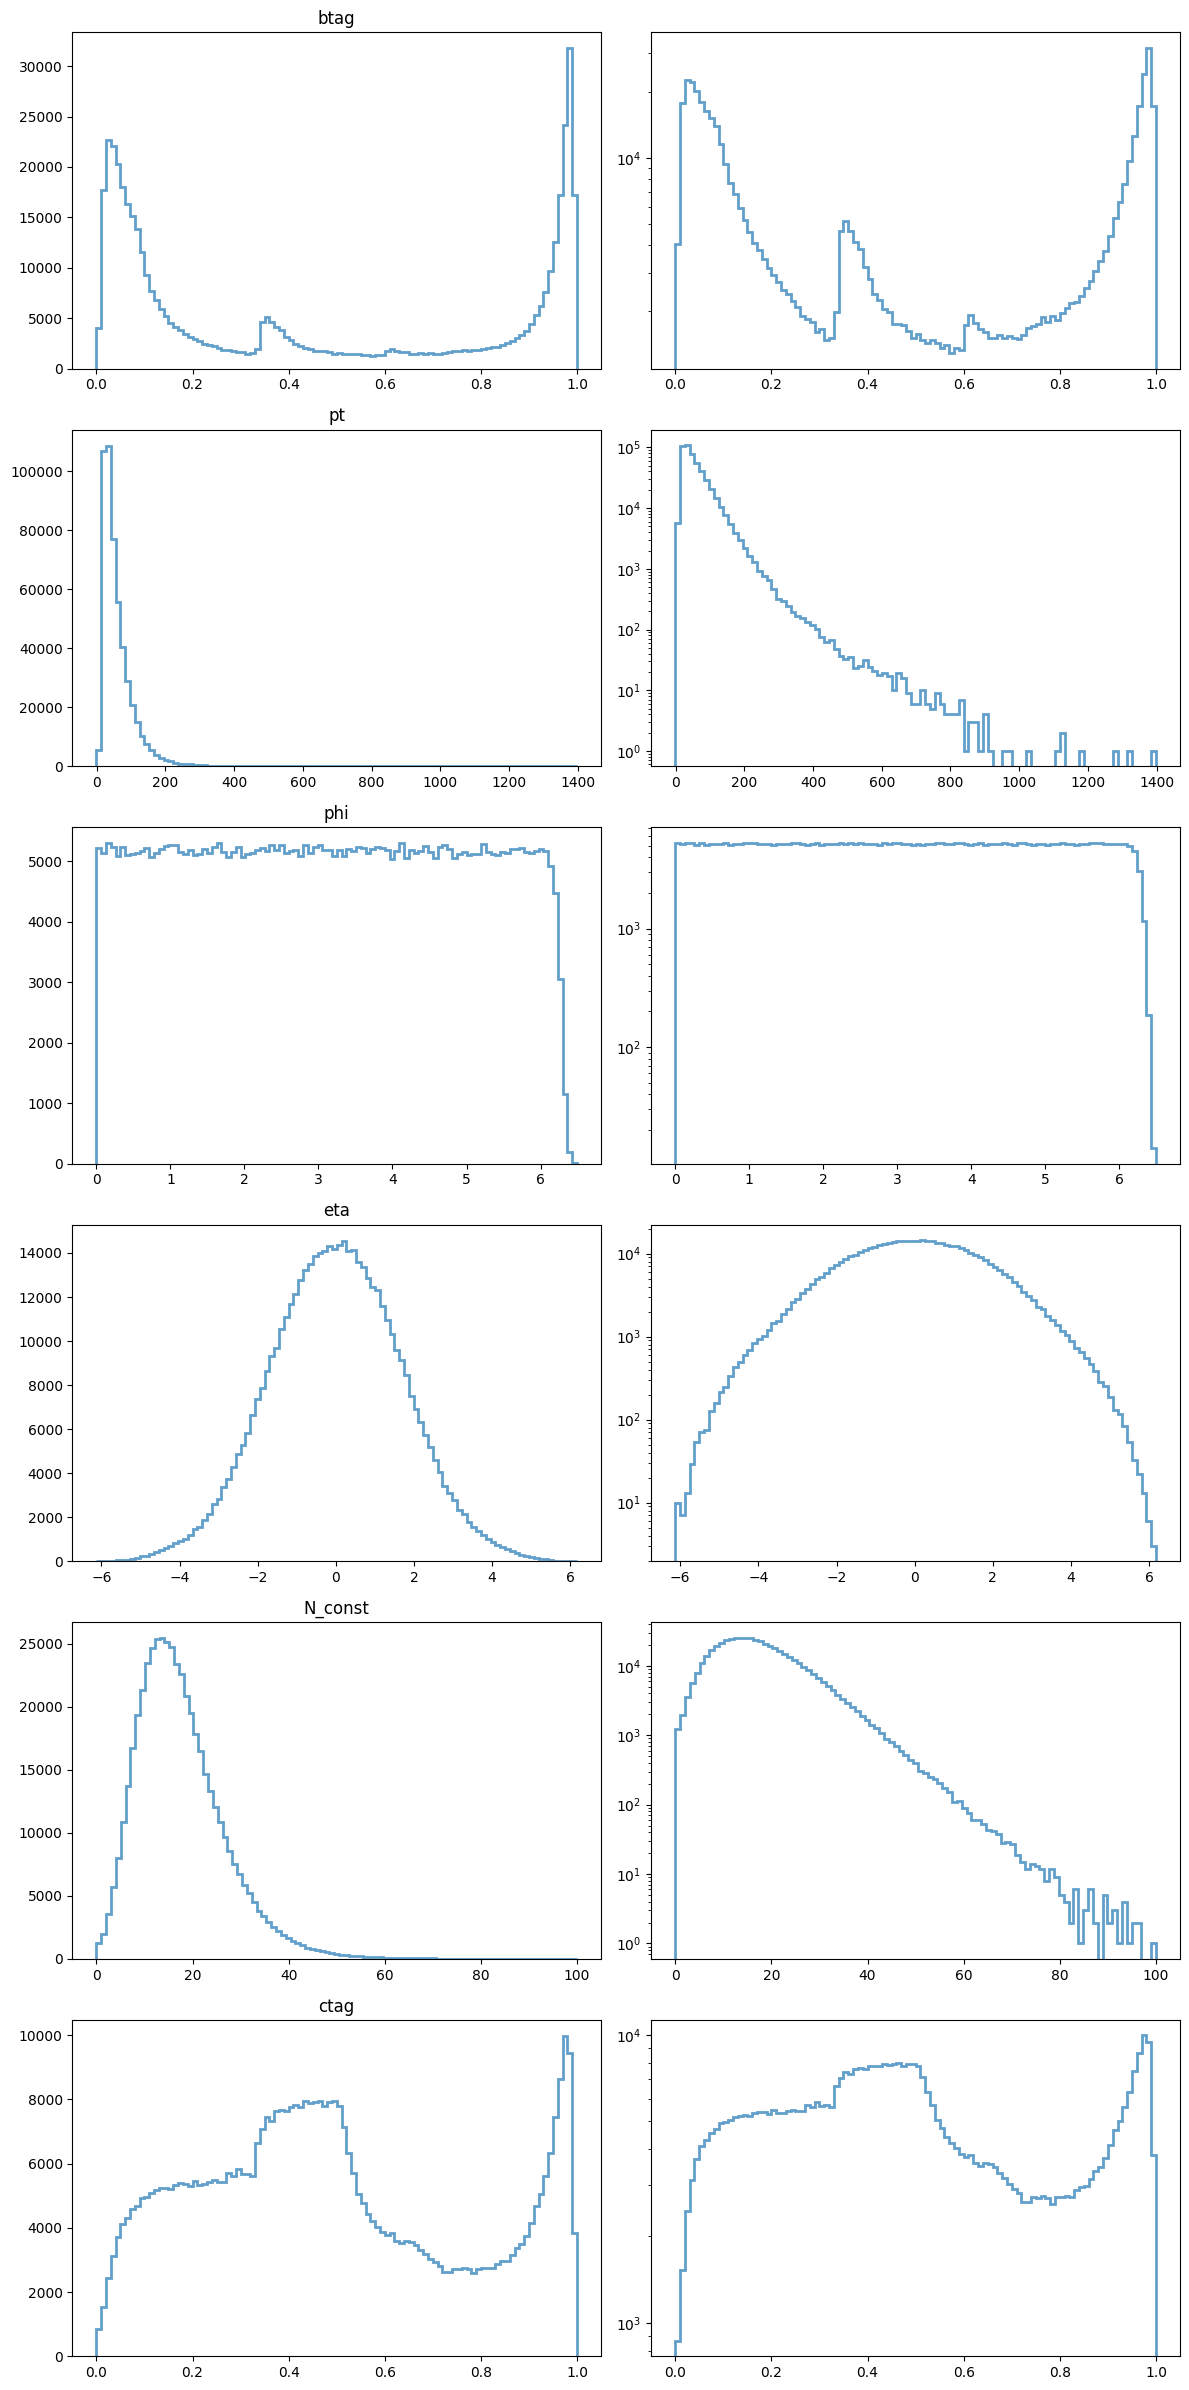

In [6]:
plot_1dhistos(reco_data, reco_features)

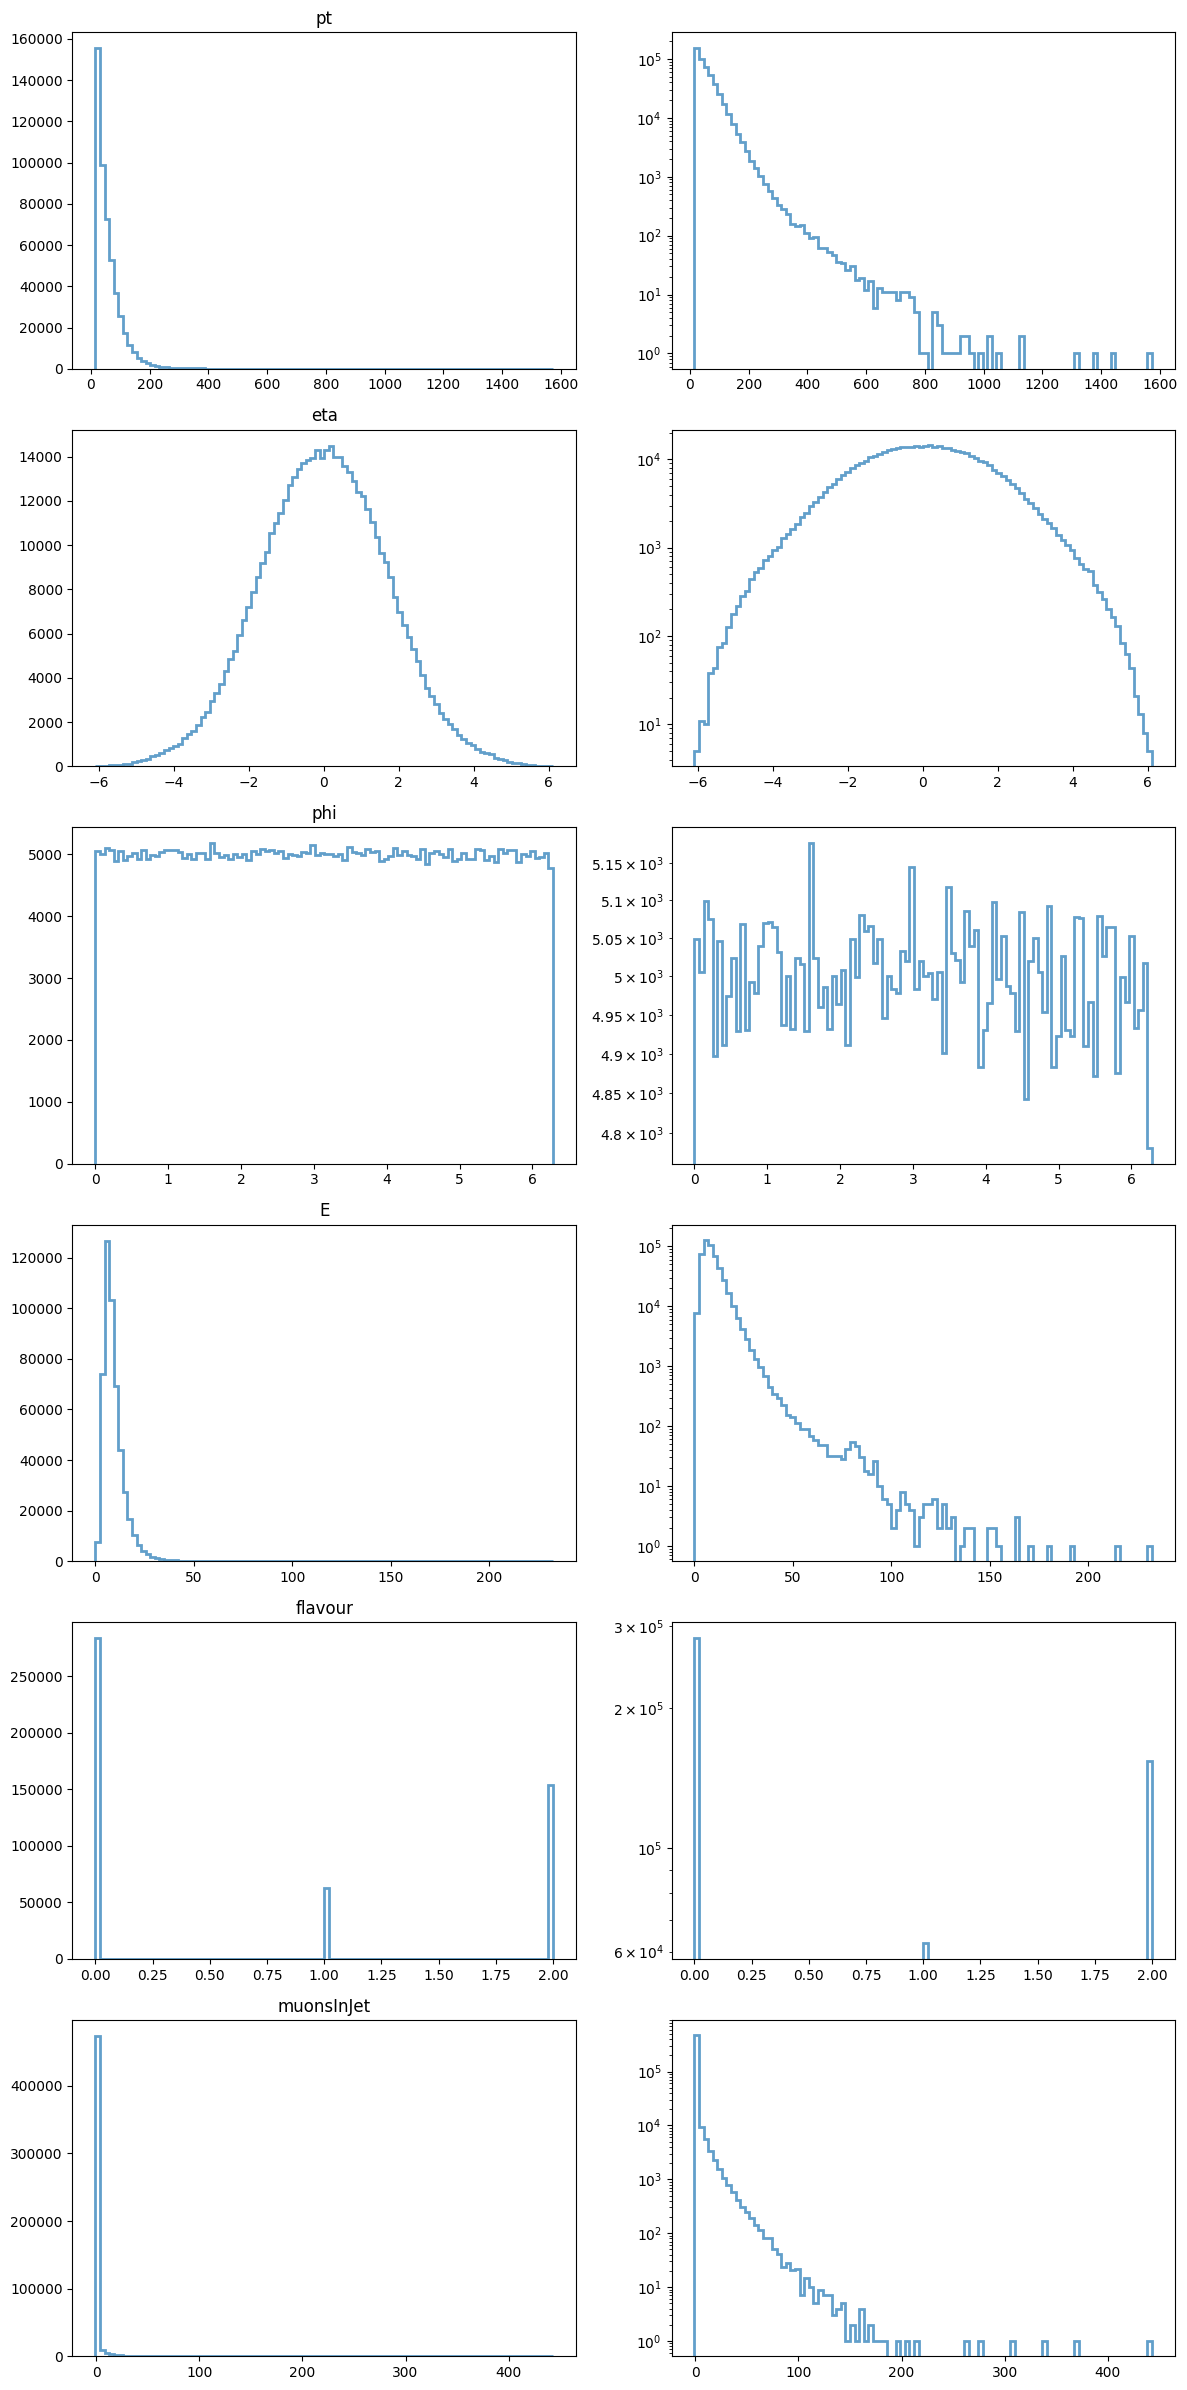

In [7]:
plot_1dhistos(gen_data, gen_features)

We can also plot the correlations between the different distributions. We would like our models to capture these as well!

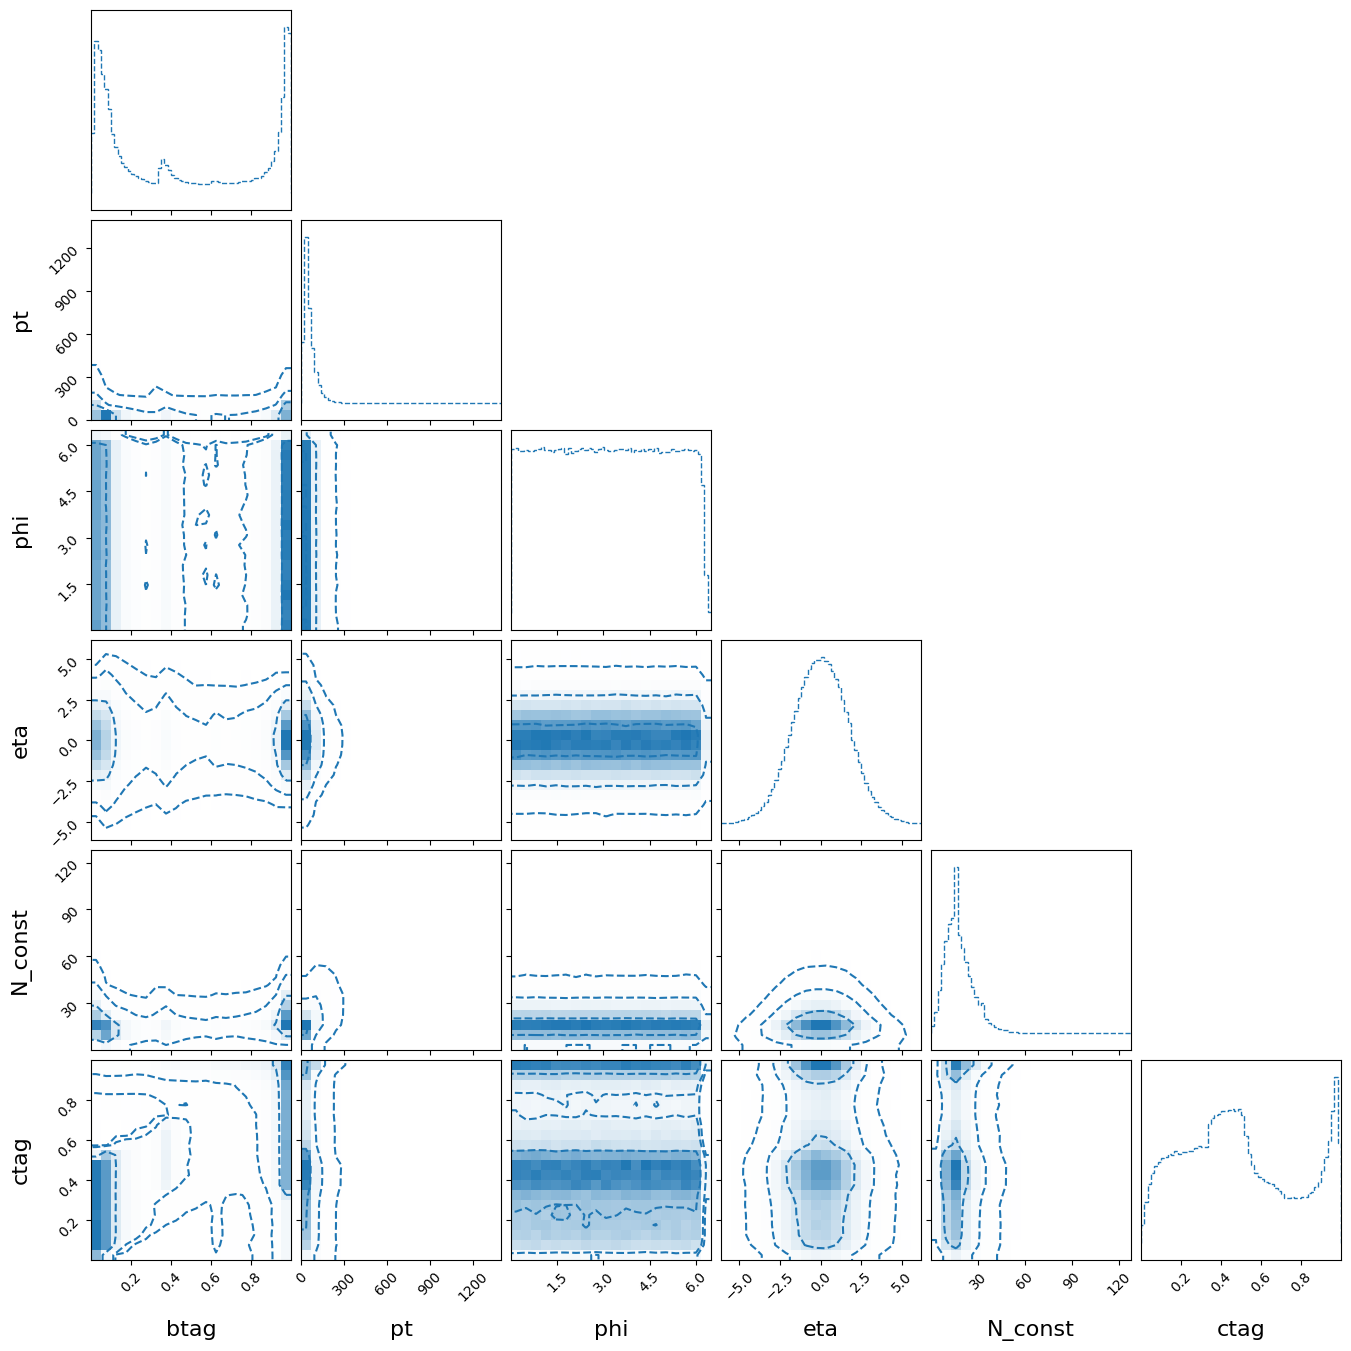

In [8]:
plot_corner(reco_data, reco_features)

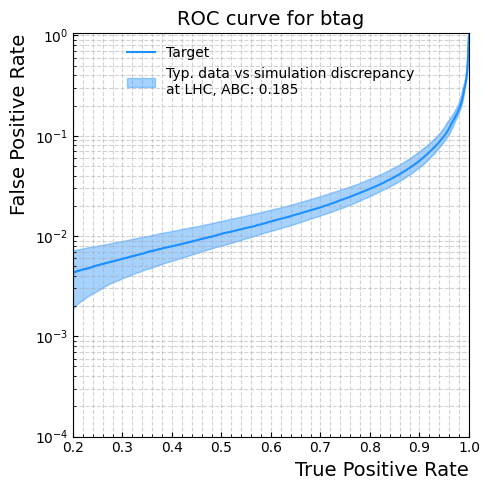

In [9]:
from utils import roc_curve_figure

roc = roc_curve_figure(reco_data, gen_data, mode='btag')

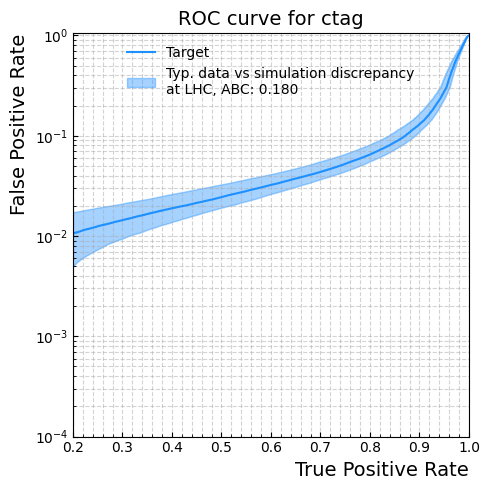

In [10]:
ctag = roc_curve_figure(reco_data, gen_data, mode='ctag')

### Preprocessing

We need to preprocess our data. 
The proposed approach is very simple: 
- we standard scale all input features (except for discrete ones);
-  for targets we learn the ratio $p_T^{\text{reco}}/p_T^{\text{gen}}$, the differences $\eta^{\text{reco}} - \eta^{\text{gen}}$ and $\phi^{\text{reco}} - \phi^{\text{gen}}$;
- we standard scale the rest. 
- We also apply some uniform smearning for the number of constituents. 

Feel free to change or add some operations if you think you need them!

In [11]:
### Preprocessor class with transform and invert methods
from sklearn.preprocessing import StandardScaler

class Preprocessor():
    def __init__(self):
        self.reco_features = ['btag', 'pt', 'phi', 'eta', 'N_const', 'ctag']
        self.gen_features = ["pt", "eta", "phi", "E", "flavour", "muonsInJet",]
        self.reco_scaler = StandardScaler()
        self.gen_scaler = StandardScaler()

    def transform(self, reco, gen):
        # smear N_const
        reco[:, 4] = reco[:, 4] + np.random.uniform(-0.5, 0.5, len(reco))
        # pt ratio
        reco[:, 1] = reco[:, 1] / gen[:, 0]
        # eta difference
        reco[:, 3] = reco[:, 3] - gen[:, 1]
        # phi difference
        reco[:, 2] = reco[:, 2] - gen[:, 2]

        # standard scale the rest
        reco[:, [0, 4, 5]] = self.reco_scaler.fit_transform(reco[:, [0, 4, 5]])
        gen[:, [0, 1, 2, 3]] = self.gen_scaler.fit_transform(gen[:, [0, 1, 2, 3]])



        return reco, gen
    
    def invert(self, reco, gen):
        

        # invert standard scaling
        reco[:, [0, 4, 5]] = self.reco_scaler.inverse_transform(reco[:, [0, 4, 5]])
        gen[:, [0, 1, 2, 3]] = self.gen_scaler.inverse_transform(gen[:, [0, 1, 2, 3]])

        # invert pt ratio
        reco[:, 1] = reco[:, 1] * gen[:, 0]
        # invert eta difference
        reco[:, 3] = reco[:, 3] + gen[:, 1]
        # invert phi difference
        reco[:, 2] = reco[:, 2] + gen[:, 2]

        # invert N_const smearing
        reco[:, 4] = np.rint(reco[:, 4])

        return reco, gen


preprocessor = Preprocessor()
reco_data, gen_data = preprocessor.transform(reco_data, gen_data)

# split the data into training and validation
from sklearn.model_selection import train_test_split

reco_train, reco_val, gen_train, gen_val = train_test_split(reco_data, gen_data, test_size=0.2)
print("Ready to train!")
print("Target data shape: ", reco_train.shape)
print("Input data shape: ", gen_train.shape)
print("Validation data shape: ", reco_val.shape)    
print("Validation data shape: ", gen_val.shape)

Ready to train!
Target data shape:  (400000, 6)
Input data shape:  (400000, 6)
Validation data shape:  (100000, 6)
Validation data shape:  (100000, 6)


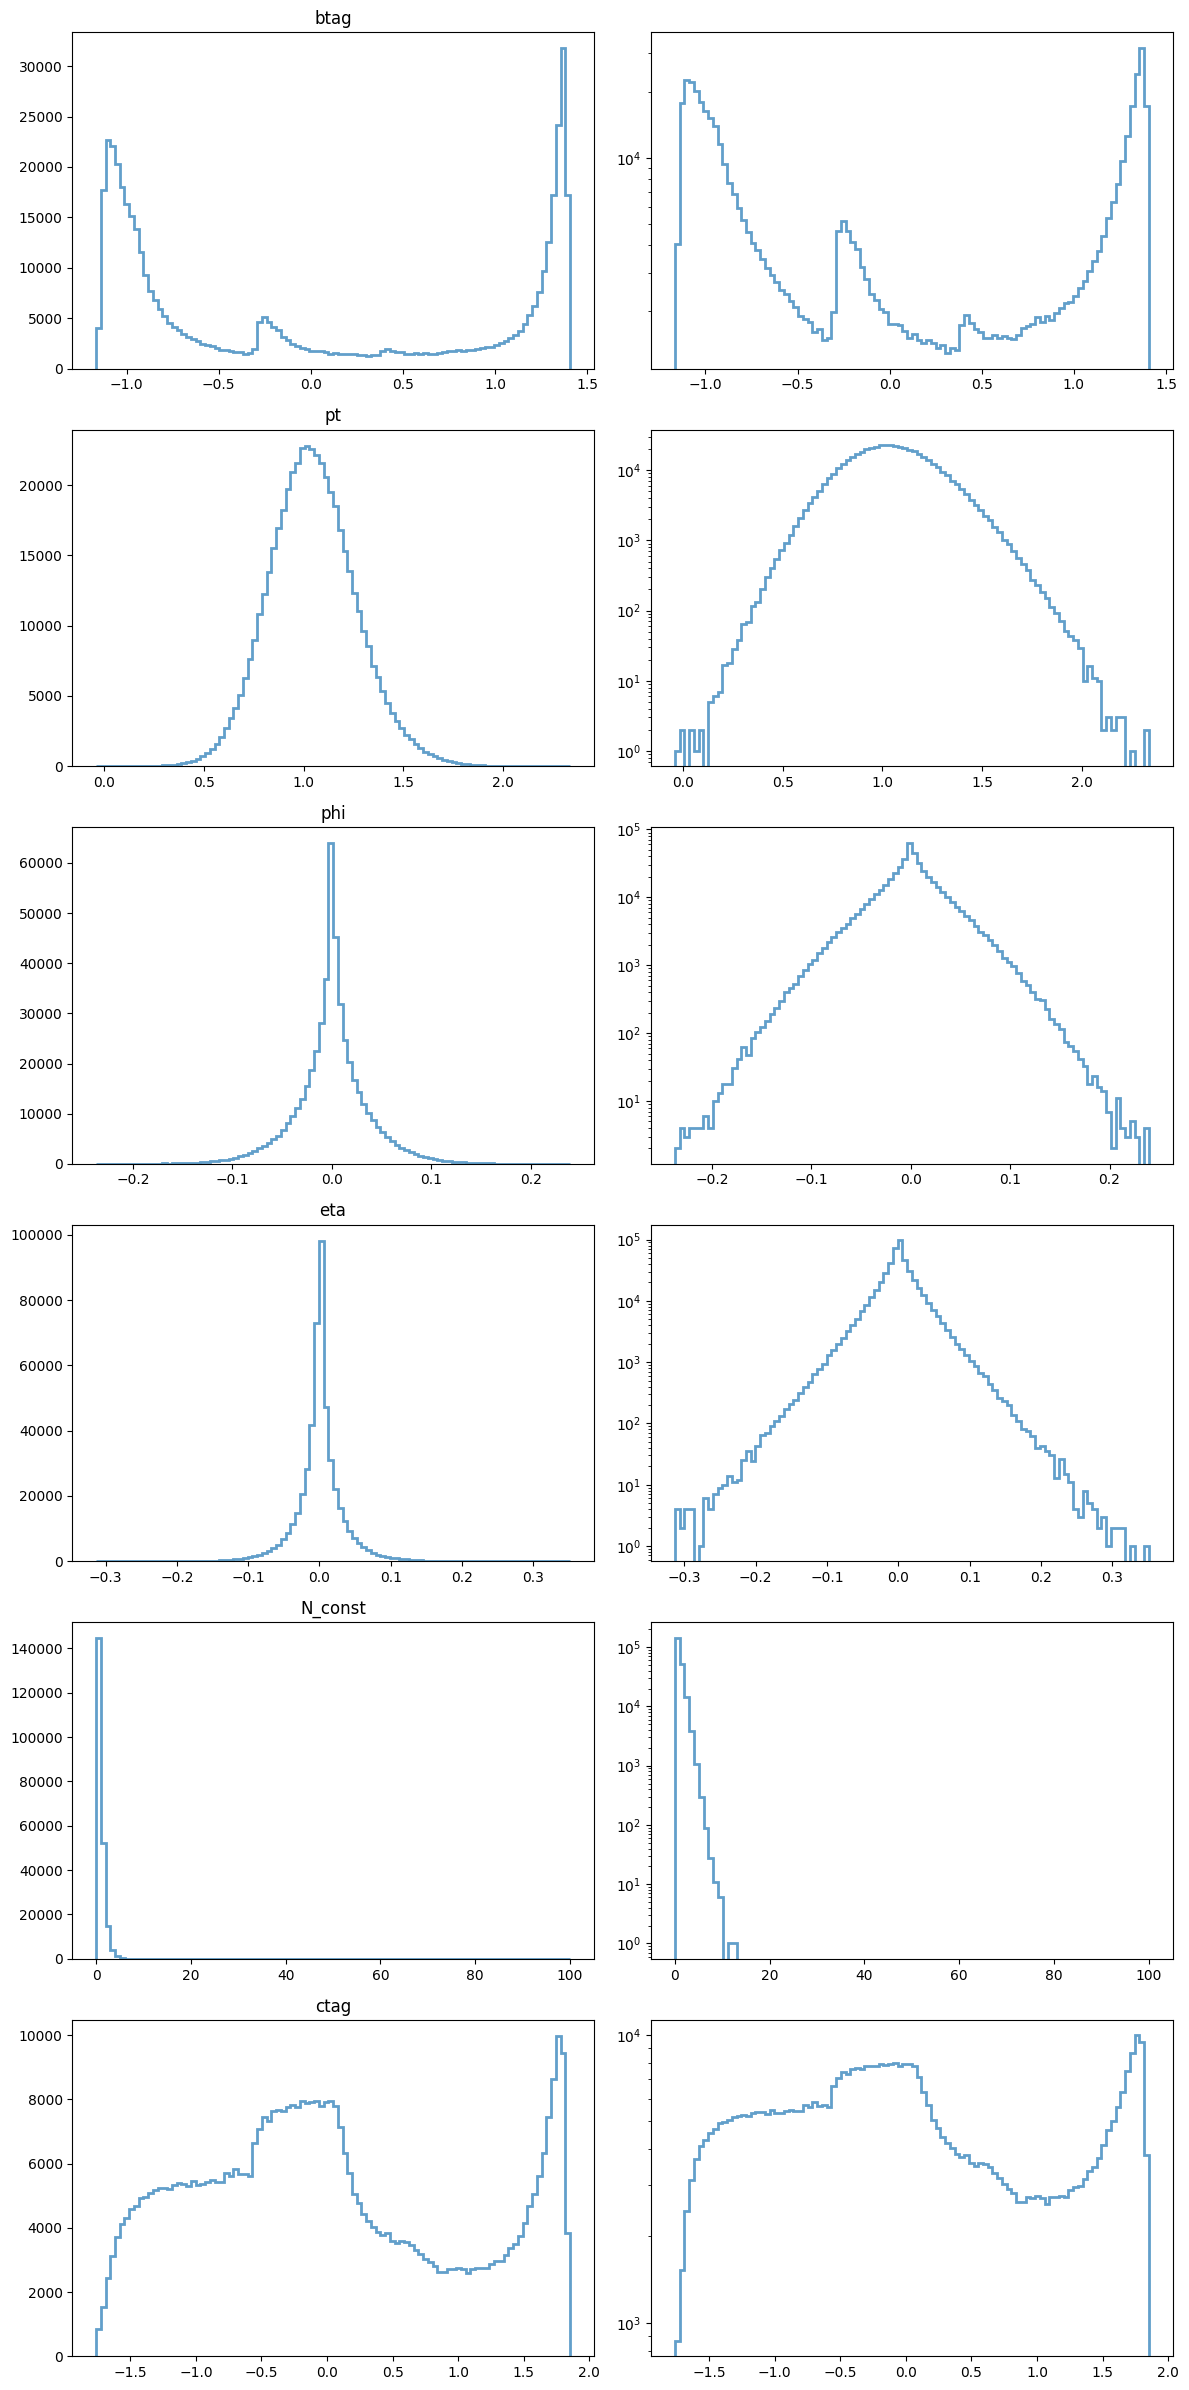

In [12]:
# plot the transformed data
plot_1dhistos(reco_data, reco_features)

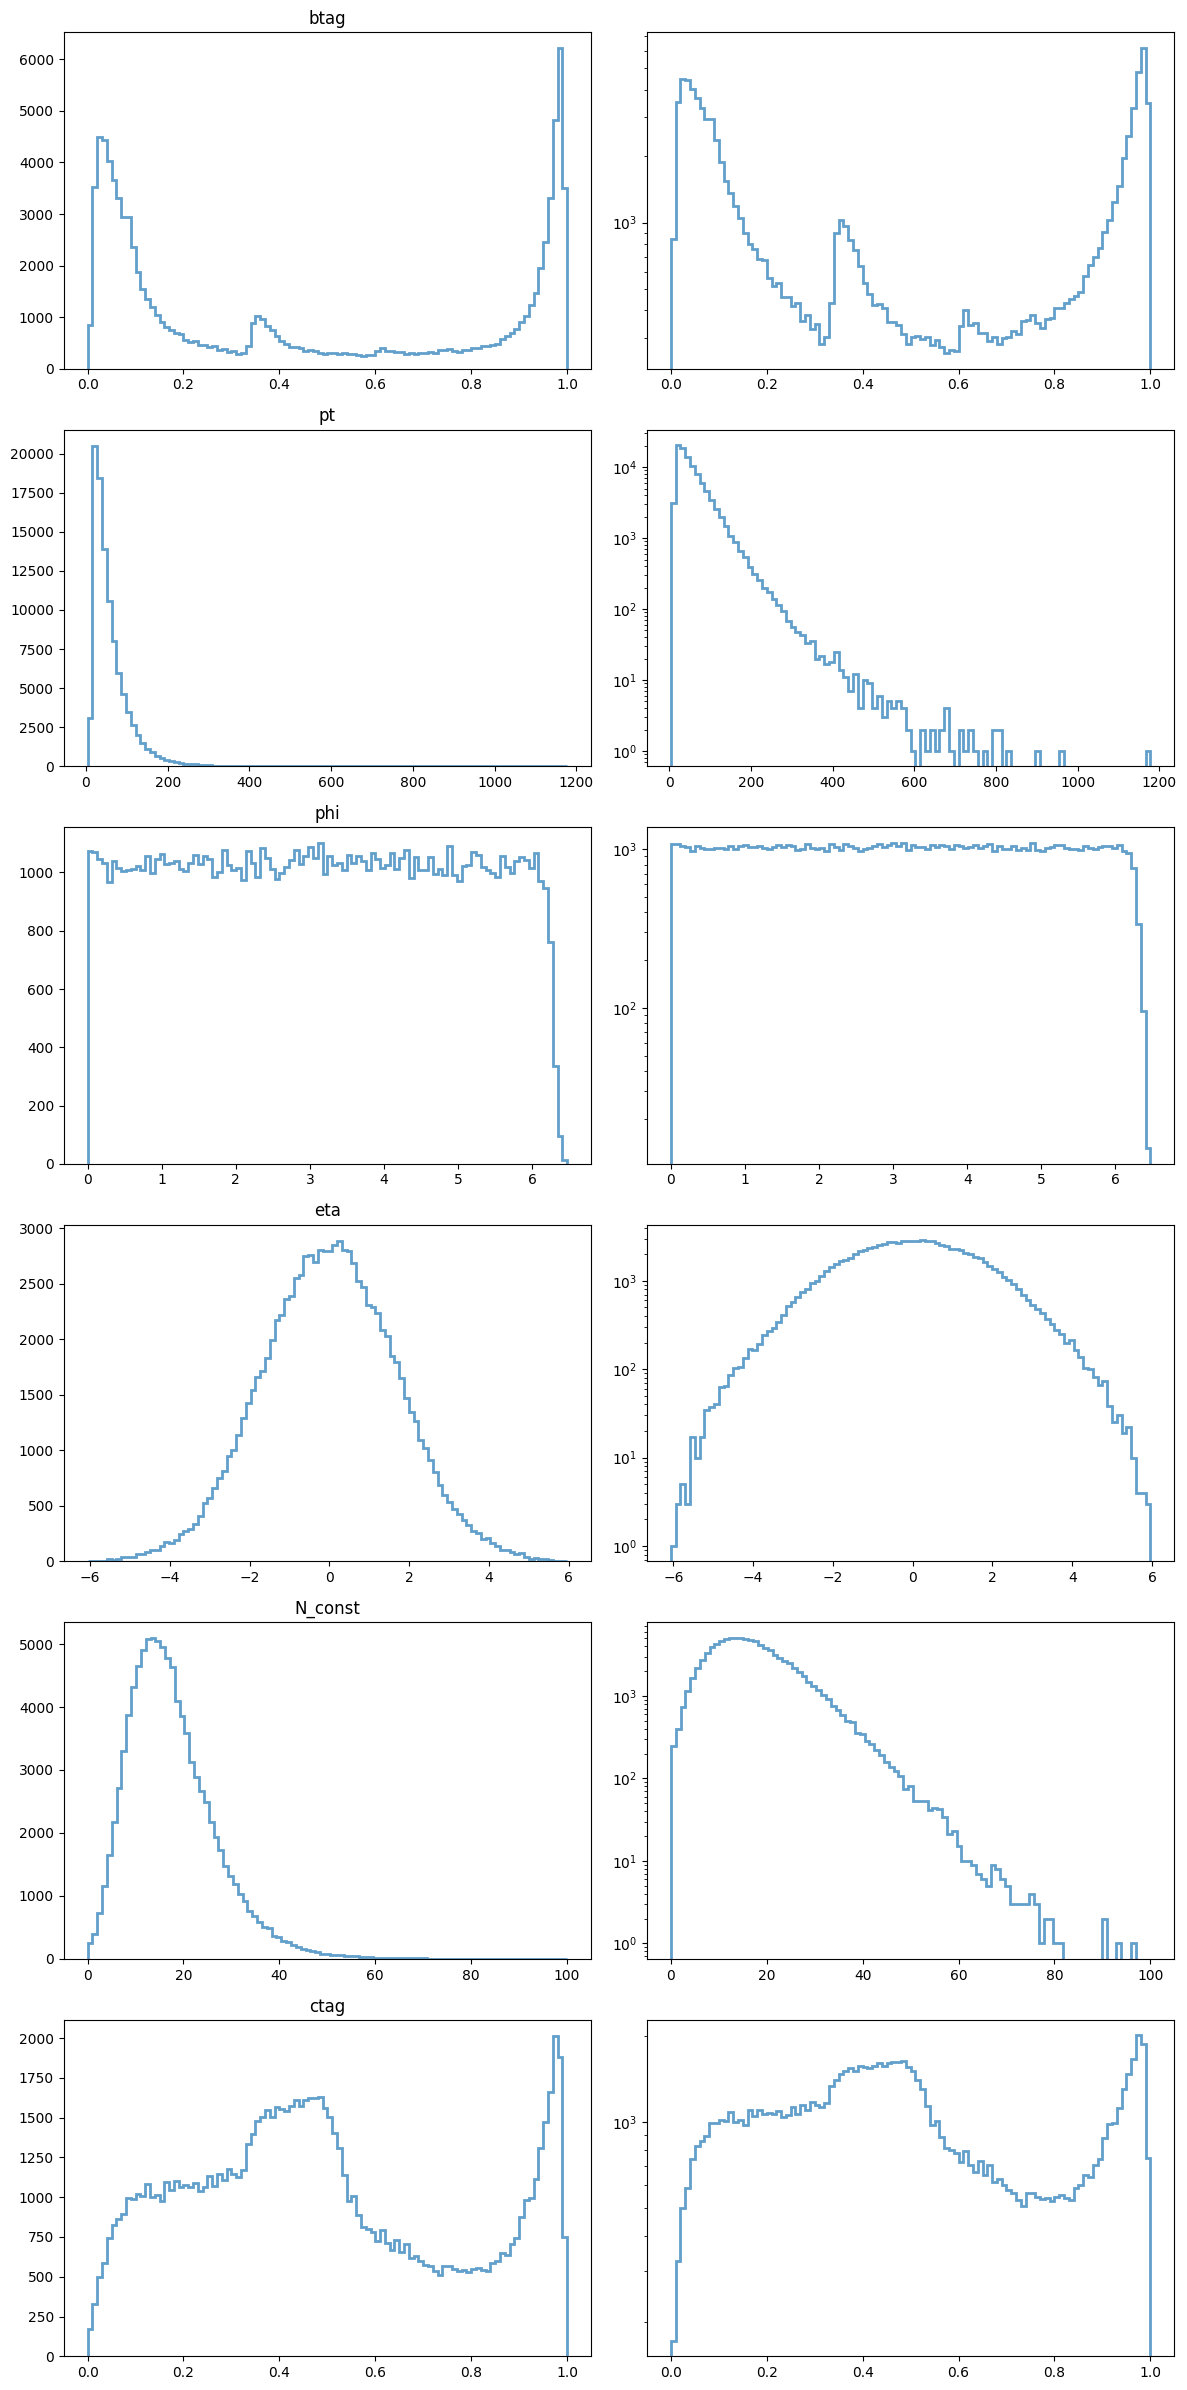

In [13]:
# now postprocess the data and plot it
reco_val_post, gen_val_post = preprocessor.invert(reco_val, gen_val)
plot_1dhistos(reco_val_post, reco_features)

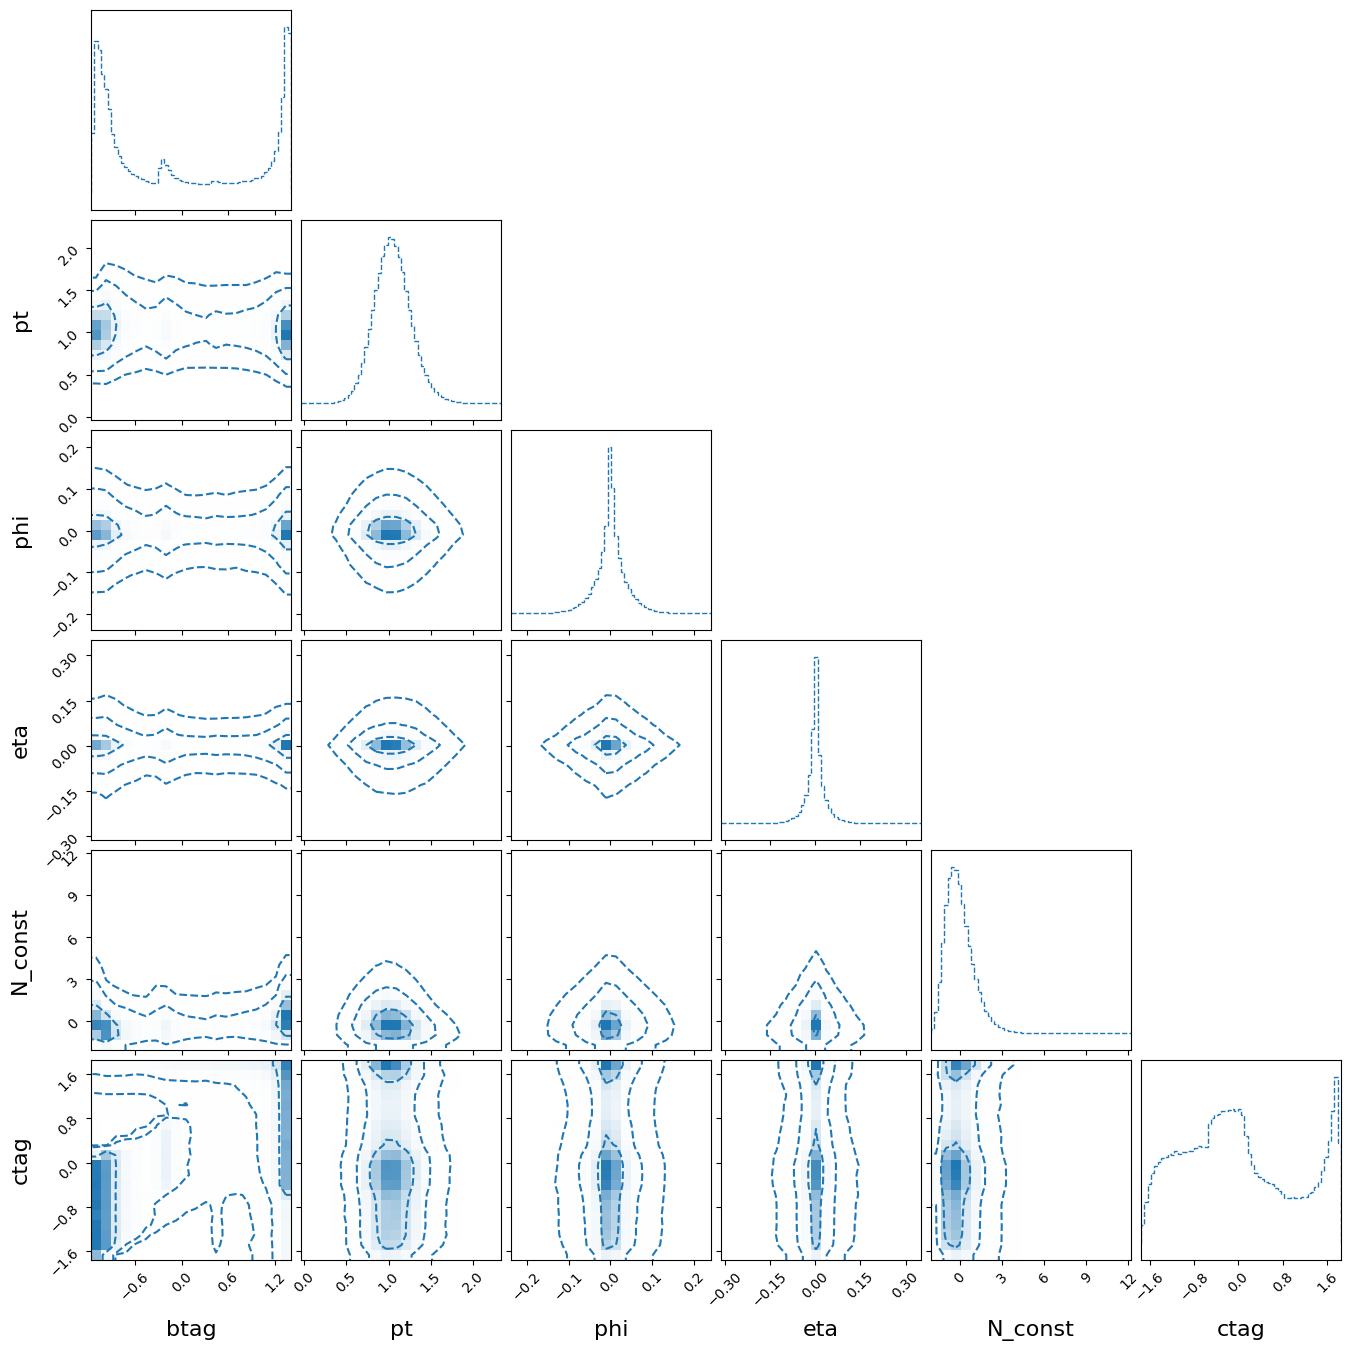

In [14]:

plot_corner(reco_data, reco_features)

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, output_dim),
            # nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator (Critic)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# WGAN Training
def train_wgan(generator, discriminator, latent_dim, real_data, gen_data, real_data_val, gen_data_val, num_epochs, batch_size, lr, critic_iterations):
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    discriminator_loss = []
    discriminator_loss_val = []
    generator_loss = []
    generator_loss_val = []

    for epoch in range(num_epochs):
        discriminator.train()
        generator.train()

        discriminator_loss_epoch = 0
        for _ in range(critic_iterations):
            for batch_idx in range(len(real_data) // batch_size):
                # Train the discriminator
                real_samples = real_data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
                latent_samples = torch.randn(len(real_samples), latent_dim).to(device)
                gen_samples = gen_data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
                fake_samples = generator(torch.cat((latent_samples, gen_samples), dim=1).to(device))

                discriminator_real = discriminator(real_samples)
                discriminator_fake = discriminator(fake_samples)

                loss_D = torch.mean(discriminator_fake) - torch.mean(discriminator_real)
                discriminator_loss_epoch += loss_D.item()
                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                # Clip discriminator weights to enforce Lipschitz constraint (WGAN)
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

        discriminator_loss.append(discriminator_loss_epoch / (critic_iterations * len(real_data) // batch_size))

        with torch.no_grad():
            fake_val_samples = generator(torch.cat((torch.randn(len(real_data_val), latent_dim).to(device), gen_data_val), dim=1)).to(device)
            val_loss_D = torch.mean(discriminator(fake_val_samples)) - torch.mean(discriminator(real_data_val))
        
        discriminator_loss_val.append(val_loss_D )

        # Train the generator
        generator_loss_epoch = 0
        for batch_idx in range(len(real_data) // batch_size):
            gen_samples = gen_data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            latent_samples = torch.randn(len(gen_samples), latent_dim).to(device)
            fake_samples = generator(torch.cat((latent_samples, gen_samples), dim=1).to(device))
            discriminator_fake = discriminator(fake_samples)

            loss_G = -torch.mean(discriminator_fake)
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
            generator_loss_epoch += loss_G.item()

        generator_loss.append(generator_loss_epoch / (len(real_data) // batch_size))


        with torch.no_grad():
            fake_val_samples = generator(torch.cat((torch.randn(len(real_data_val), latent_dim).to(device), gen_data_val), dim=1)).to(device)
            val_loss_G = -torch.mean(discriminator(fake_val_samples))

        generator_loss_val.append(val_loss_G / (len(real_data) // batch_size))

        # Print training progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {discriminator_loss[-1]:.4f}, Generator Loss: {generator_loss[-1]:.4f}")

    return discriminator_loss, generator_loss, discriminator_loss_val, generator_loss_val



In [37]:
# Example usage
latent_dim = 6
output_dim = 6
reco_train = torch.tensor(reco_train, dtype=torch.float32).to(device)
gen_train = torch.tensor(gen_train, dtype=torch.float32).to(device)
reco_val = torch.tensor(reco_val, dtype=torch.float32).to(device)
gen_val = torch.tensor(gen_val, dtype=torch.float32).to(device)

generator = Generator(latent_dim*2, output_dim).to(device)
discriminator = Discriminator(output_dim).to(device)

/tmp/ipykernel_30067/3112154022.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reco_train = torch.tensor(reco_train, dtype=torch.float32).to(device)
/tmp/ipykernel_30067/3112154022.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_train = torch.tensor(gen_train, dtype=torch.float32).to(device)
/tmp/ipykernel_30067/3112154022.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reco_val = torch.tensor(reco_val, dtype=torch.float32).to(device)
/tmp/ipykernel_30067/3112154022.py:7: UserWarning: To copy construct from a tensor, it i

In [38]:
# torchsummary of models
from torchsummary import summary

print(summary(generator, (latent_dim*2,)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             416
         LeakyReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
         LeakyReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 6]             774
Total params: 28,134
Trainable params: 28,134
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.11
Estimated Total Size (MB): 0.11
---------------------------------------------

In [39]:
print(summary(discriminator, (output_dim,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             224
         LeakyReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
         LeakyReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
        LeakyReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 35,489
Trainable params: 35,489
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [40]:
num_epochs = 50
batch_size = 128
lr = 0.0001
critic_iterations = 5

discriminator_loss, generator_loss, discriminator_loss_val, generator_loss_val = train_wgan(generator, discriminator, latent_dim, reco_train, gen_train, reco_val, gen_val, num_epochs, batch_size, lr, critic_iterations)

Epoch [1/50], Discriminator Loss: -0.0008, Generator Loss: -533.3088
Epoch [2/50], Discriminator Loss: -3849.4241, Generator Loss: 1277.9750
Epoch [3/50], Discriminator Loss: -372.4558, Generator Loss: 164.0950


KeyboardInterrupt: 

In [41]:
# plot the losses
plt.plot(discriminator_loss[60:], label='Discriminator Loss')
plt.plot(generator_loss[60:], label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'discriminator_loss' is not defined

In [43]:
# Generate samples from the trained generator
latent_samples = torch.randn(len(reco_val), latent_dim).to(device)
gen_samples = torch.tensor(gen_val, dtype=torch.float32).to(device)

fake_samples = generator(torch.cat((latent_samples, gen_samples), dim=1).to(device)).detach().cpu().numpy()
# postprocess the generated samples
fake_samples, gen_val = preprocessor.invert(fake_samples, gen_val.cpu().numpy())

/tmp/ipykernel_30067/1461499805.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_samples = torch.tensor(gen_val, dtype=torch.float32).to(device)


/home/users/fvaselli/iCSC/utils.py:333: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(hist_flash) / hist_flash) ** 2 + (np.sqrt(hist_reco) / hist_reco) ** 2
/home/users/fvaselli/iCSC/utils.py:335: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:336: RuntimeWarning: invalid value encountered in divide
  ratio = hist_flash / hist_reco


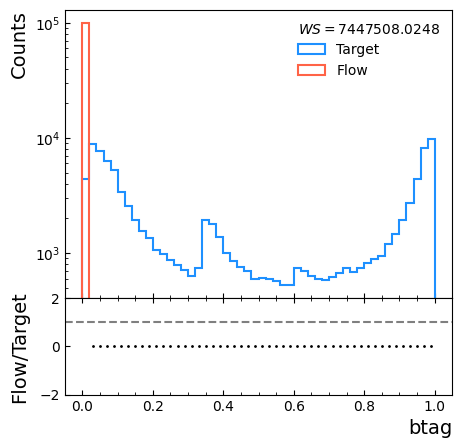

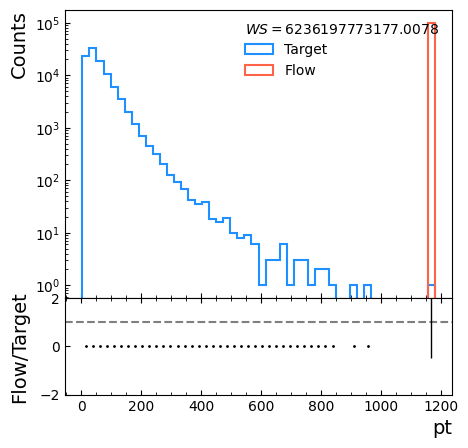

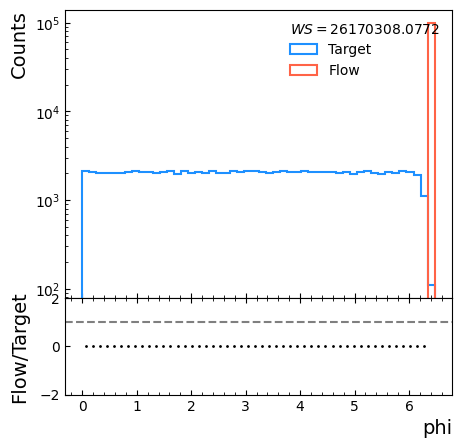

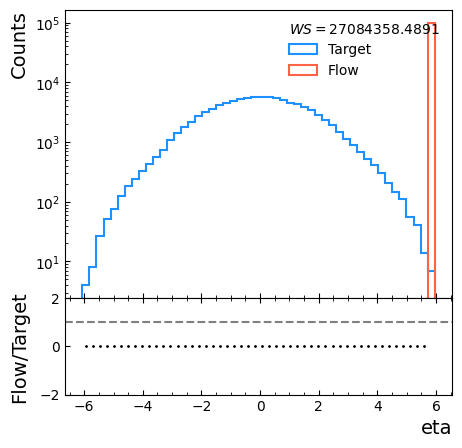

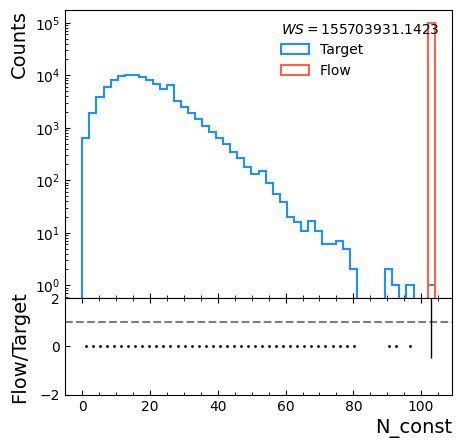

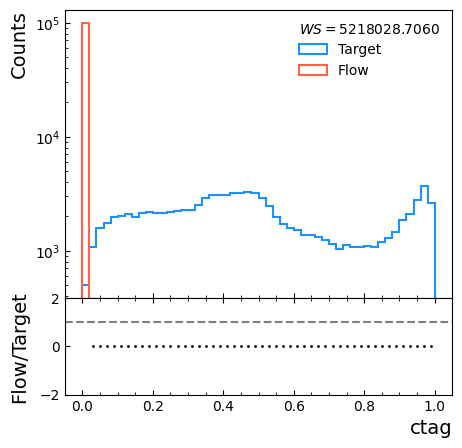

In [44]:
# plot the generated data
from utils import plot_1d_hist

# reco_val_post = preprocessor.invert(reco_val, gen_val)[0]

for i in range(6):
    plot_1d_hist(fake_samples[:, i], reco_val_post[:, i], label=reco_features[i], title=f'Generated vs Real {reco_features[i]}', bins=50, logScale=True)

In [49]:
### VAE

import torch
import torch.nn as nn
import torch.optim as optim

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_gen = nn.Linear(output_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, z, gen):
        h = self.relu(self.fc1(z))
        h_gen = self.relu(self.fc_gen(gen))
        h = torch.cat((h, h_gen), dim=1)
        h = self.relu(self.fc2(h))
        x_recon = self.fc3(h)
        return x_recon

# VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, gen):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z, gen)
        return x_recon, mu, log_var

# VAE Training
def train_vae(vae, reco, gen, reco_val, gen_val, num_epochs, batch_size, lr):
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    loss_train = []
    loss_val = []

    for epoch in range(num_epochs):
        for batch_idx in range(len(reco) // batch_size):
            batch = reco[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            batch_gen = gen[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            x_recon, mu, log_var = vae(batch, batch_gen)
            recon_loss = nn.MSELoss()(x_recon, batch)
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + kl_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        with torch.no_grad():
            x_recon_val, mu_val, log_var_val = vae(reco_val, gen_val)
            recon_loss_val = nn.MSELoss()(x_recon_val, reco_val)
            kl_loss_val = -0.5 * torch.sum(1 + log_var_val - mu_val.pow(2) - log_var_val.exp())
            loss_val = recon_loss_val + kl_loss_val
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    return loss_train, loss_val

In [50]:
vae = VAE(input_dim=6, hidden_dim=32, latent_dim=6).to(device)
summary(vae, [(6,),(6,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             224
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 6]             198
            Linear-6                    [-1, 6]             198
           Encoder-7         [[-1, 6], [-1, 6]]               0
            Linear-8                   [-1, 32]             224
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 32]             224
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 32]           2,080
             ReLU-13                   [-1, 32]               0
           Linear-14                   

In [51]:
num_epochs = 50
batch_size = 128
lr = 0.001
reco_train = torch.tensor(reco_train, dtype=torch.float32).to(device)
gen_train = torch.tensor(gen_train, dtype=torch.float32).to(device)
reco_val = torch.tensor(reco_val, dtype=torch.float32).to(device)
gen_val = torch.tensor(gen_val, dtype=torch.float32).to(device)


loss_train, loss_val = train_vae(vae, reco_train, gen_train, reco_val, gen_val, num_epochs, batch_size, lr)


/tmp/ipykernel_30067/2910369478.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reco_train = torch.tensor(reco_train, dtype=torch.float32).to(device)
/tmp/ipykernel_30067/2910369478.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_train = torch.tensor(gen_train, dtype=torch.float32).to(device)
/tmp/ipykernel_30067/2910369478.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reco_val = torch.tensor(reco_val, dtype=torch.float32).to(device)
/tmp/ipykernel_30067/2910369478.py:7: UserWarning: To copy construct from a tensor, it i

Epoch [1/50], Loss: 0.2153
Epoch [2/50], Loss: 0.2142
Epoch [3/50], Loss: 0.2128
Epoch [4/50], Loss: 0.2119
Epoch [5/50], Loss: 0.2127
Epoch [6/50], Loss: 0.2126
Epoch [7/50], Loss: 0.2116
Epoch [8/50], Loss: 0.2116
Epoch [9/50], Loss: 0.2112
Epoch [10/50], Loss: 0.2111
Epoch [11/50], Loss: 0.2109
Epoch [12/50], Loss: 0.2099
Epoch [13/50], Loss: 0.2099
Epoch [14/50], Loss: 0.2094
Epoch [15/50], Loss: 0.2095
Epoch [16/50], Loss: 0.2098
Epoch [17/50], Loss: 0.2093
Epoch [18/50], Loss: 0.2089
Epoch [19/50], Loss: 0.2091
Epoch [20/50], Loss: 0.2088
Epoch [21/50], Loss: 0.2083
Epoch [22/50], Loss: 0.2079
Epoch [23/50], Loss: 0.2080
Epoch [24/50], Loss: 0.2080
Epoch [25/50], Loss: 0.2072
Epoch [26/50], Loss: 0.2075
Epoch [27/50], Loss: 0.2069
Epoch [28/50], Loss: 0.2067
Epoch [29/50], Loss: 0.2073
Epoch [30/50], Loss: 0.2074
Epoch [31/50], Loss: 0.2071
Epoch [32/50], Loss: 0.2071
Epoch [33/50], Loss: 0.2076
Epoch [34/50], Loss: 0.2069
Epoch [35/50], Loss: 0.2070


KeyboardInterrupt: 

/tmp/ipykernel_30067/49962766.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reco_val = torch.tensor(reco_val, dtype=torch.float32).to(device)
/tmp/ipykernel_30067/49962766.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_val = torch.tensor(gen_val, dtype=torch.float32).to(device)
/home/users/fvaselli/iCSC/utils.py:333: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(hist_flash) / hist_flash) ** 2 + (np.sqrt(hist_reco) / hist_reco) ** 2
/home/users/fvaselli/iCSC/utils.py:335: RuntimeWarning: divide by zero encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/users/fvaselli/iCSC/utils.py:336: RuntimeWarning: divide by zero encountered i

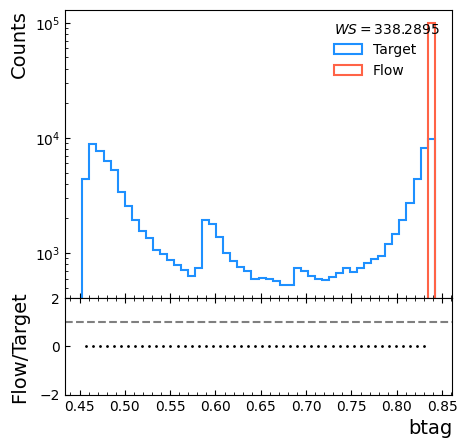

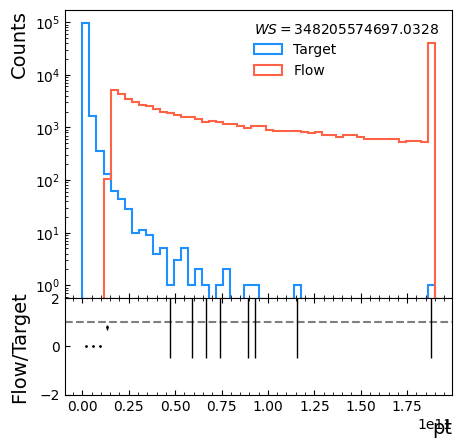

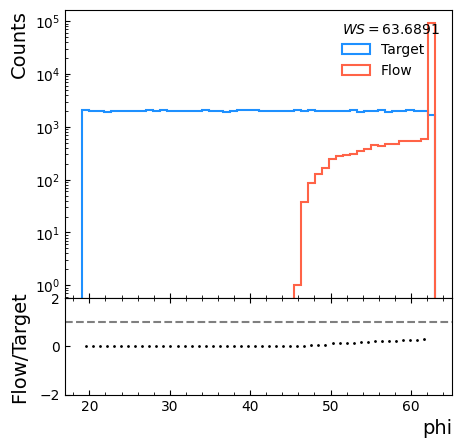

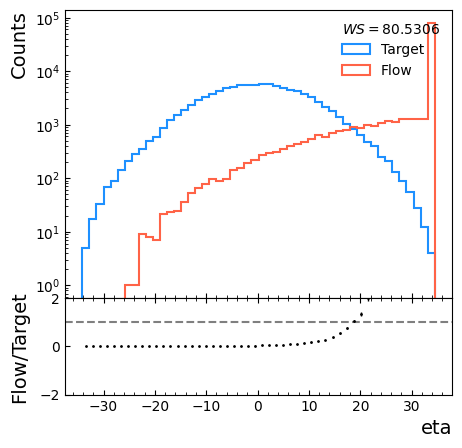

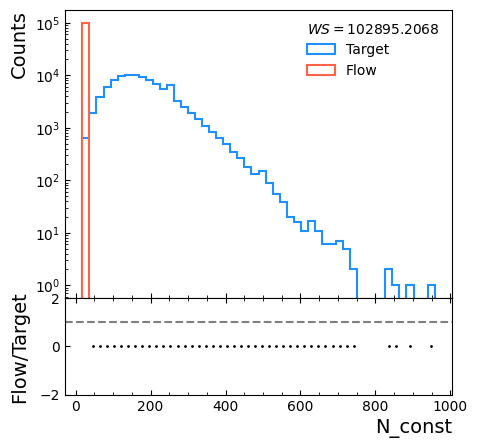

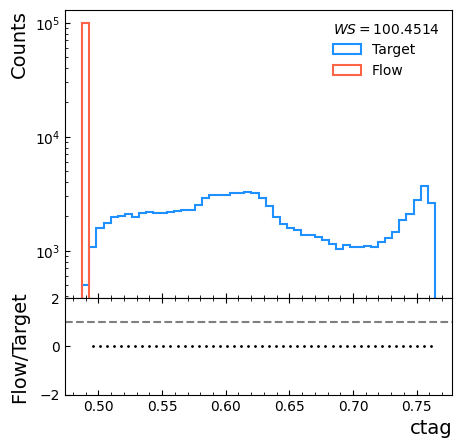

In [52]:
# generate
with torch.no_grad():
    reco_val = torch.tensor(reco_val, dtype=torch.float32).to(device)
    gen_val = torch.tensor(gen_val, dtype=torch.float32).to(device)
    x_recon, _, _ = vae(reco_val, gen_val)
    x_recon = x_recon.cpu().numpy()
    reco_val = reco_val.cpu().numpy()
    reco_val, gen_val = preprocessor.invert(reco_val, gen_val.cpu().numpy())
    x_recon, gen_val = preprocessor.invert(x_recon, gen_val)

for i in range(6):
    plot_1d_hist(x_recon[:, i], reco_val[:, i], label=reco_features[i], title=f'Reconstructed vs Real {reco_features[i]}', bins=50, logScale=True)